# HPH第三版实验

### 思路

*id统计相关*
1. item_id, shop_id的交易量, 交易率
2. item_id, shop_id7天是否新出现, 3天是否新出现, 昨天是否新出现
3. 提交并且验证线上分数

In [135]:
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

train_df = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
test_df = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')

# 线下线上数据统一进行特征处理
test_df['is_trade'] = -1
total_df = train_df #pd.concat([train_df, test_df], axis=0, ignore_index=True)

# 1 数据集统一处理

In [136]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from sklearn import preprocessing
from datetime import datetime
le = preprocessing.LabelEncoder()

def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime('%Y-%m-%d')
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

total_df['date'] = total_df['context_timestamp'].apply(lambda x: extract_date(x))
total_df['day'] = le.fit_transform(total_df['date'])
total_df['weekday'] = total_df['context_timestamp'].apply(lambda x: extract_weekday(x))
total_df['hour'] = total_df['context_timestamp'].apply(lambda x: extract_hour(x))

In [137]:
def getStage(h):
    if h in [19, 20, 21, 22]:
        return 0
    elif h in [23, 18, 17, 16, 15, 14, 13, 12, 11, 10]:
        return 1
    elif h in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        return 2


total_df['hour_stage'] = total_df['hour'].map(lambda x: getStage(x))

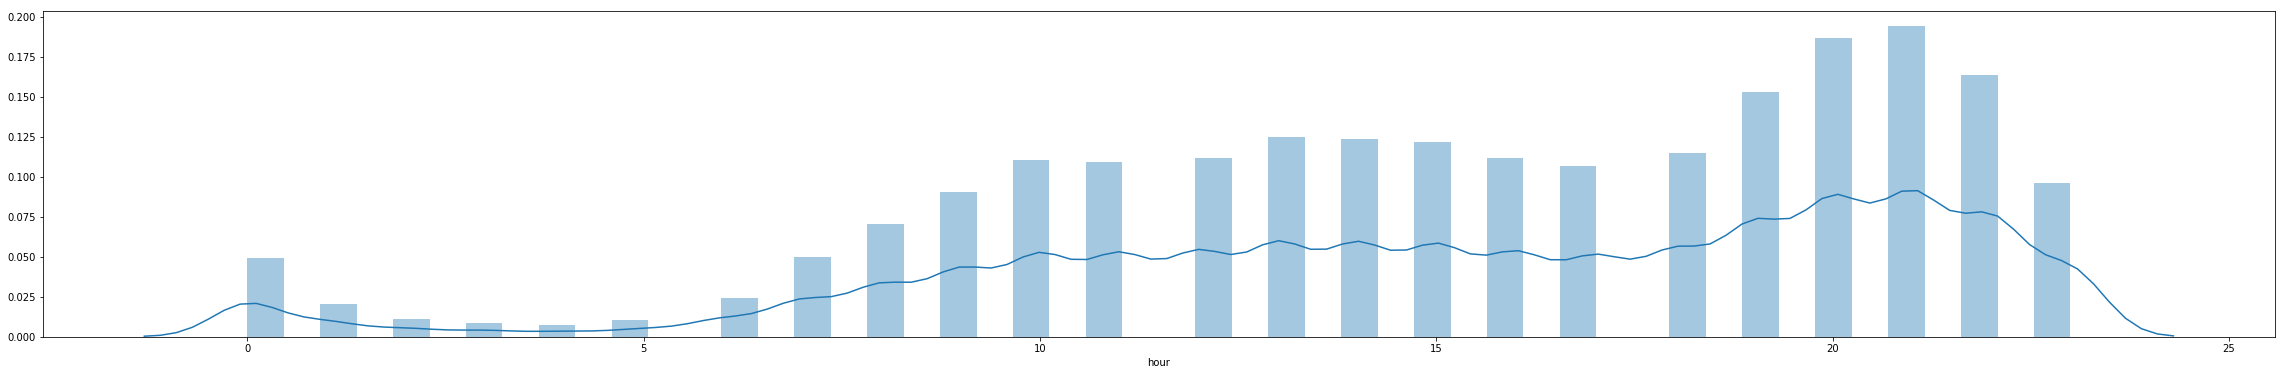

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 1, figsize=(40, 6))
sns.distplot(total_df['hour'], ax=ax)
#total_df['hour'].plot(kind='hist')

In [ ]:
%run ../util/time_utils.py
for i in range(1, 8):

    total_df = getColDupByDate(total_df, 'date', 'item_id', i)
    total_df = getColDupByDate(total_df, 'date', 'item_brand_id', i)
    total_df = getColDupByDate(total_df, 'date', 'shop_id', i)
    total_df = getColDupByDate(total_df, 'date', 'user_id', i)

In [ ]:
total_df[total_df['day'] == 6]

In [82]:
# 计算前一天的交易率set到下一天，第0天用回自己
%run ../util/time_utils.py

setTradeRateByDate(total_df, ['item_city_id', 'item_id', 'item_brand_id', 'shop_id', 'user_id'])

cal item_city_id trade_rate cnt 0 set to 0
days1 unique: [0]
cal item_city_id trade_rate cnt 0 set to 1
days1 unique: [0]
cal item_city_id trade_rate cnt 1 set to 2
days1 unique: [0 1]
cal item_city_id trade_rate cnt 2 set to 3
days1 unique: [0 1 2]
cal item_city_id trade_rate cnt 3 set to 4
days1 unique: [0 3 1 2]
cal item_city_id trade_rate cnt 4 set to 5
days1 unique: [0 3 1 2 4]
cal item_city_id trade_rate cnt 5 set to 6
days1 unique: [0 3 1 2 4 5]
cal item_id trade_rate cnt 0 set to 0
days1 unique: [0]
cal item_id trade_rate cnt 0 set to 1
days1 unique: [0]
cal item_id trade_rate cnt 1 set to 2
days1 unique: [0 1]
cal item_id trade_rate cnt 2 set to 3
days1 unique: [0 1 2]
cal item_id trade_rate cnt 3 set to 4
days1 unique: [0 3 1 2]
cal item_id trade_rate cnt 4 set to 5
days1 unique: [0 3 1 2 4]
cal item_id trade_rate cnt 5 set to 6
days1 unique: [0 3 1 2 4 5]
cal item_brand_id trade_rate cnt 0 set to 0
days1 unique: [0]
cal item_brand_id trade_rate cnt 0 set to 1
days1 unique: [

In [83]:
total_df.columns.values

array(['instance_id', 'item_id', 'item_category_list',
       'item_property_list', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'date', 'day', 'weekday',
       'hour', 'item_id_dup_g_1', 'item_brand_id_dup_g_1',
       'shop_id_dup_g_1', 'user_id_dup_g_1', 'item_id_dup_g_2',
       'item_brand_id_dup_g_2', 'shop_id_dup_g_2', 'user_id_dup_g_2',
       'item_id_dup_g_3', 'item_brand_id_dup_g_3', 'shop_id_dup_g_3',
       'user_id_dup_g_3', 'item_id_dup_g_4', 'item_brand_id_dup_g_4',
       'shop_id_dup_g_4', 'user_id_dup_g_4', 'item_id_du

In [84]:
# 分桶
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# total_df['item_city_id_pv_cut'] = pd.cut(total_df['item_city_id_pv'].values, bins=10, retbins=False)
# total_df['item_id_pv_cut'] = pd.cut(total_df['item_id_pv'].values, bins=10, retbins=False)
# total_df['shop_id_pv_cut'] = pd.cut(total_df['shop_id_pv'].values, bins=10, retbins=False)
# total_df['item_brand_id_pv_cut'] = pd.cut(total_df['item_brand_id_pv'].values, bins=10, retbins=False)
# total_df['user_occupation_id_pv_cut'] = pd.cut(total_df['user_occupation_id_pv'].values, bins=10, retbins=False)

# total_df['item_city_id_pv_cut'] = le.fit_transform(total_df['item_city_id_pv_cut'].copy())
# total_df['item_id_pv_cut'] = le.fit_transform(total_df['item_id_pv_cut'].copy())
# total_df['shop_id_pv_cut'] = le.fit_transform(total_df['shop_id_pv_cut'].copy())
# total_df['item_brand_id_pv_cut'] = le.fit_transform(total_df['item_brand_id_pv_cut'].copy())
# total_df['user_occupation_id_pv_cut'] = le.fit_transform(total_df['user_occupation_id_pv_cut'].copy())

In [112]:
# standardization and scaling

from sklearn import preprocessing

def scale(df, idCol):
    min_max_scaler = preprocessing.RobustScaler()
    a = min_max_scaler.fit_transform(df[idCol].values.reshape(-1, 1))
    return pd.Series(a.reshape(1, -1)[0])

# 令数据再少一些?
total_df['shop_score_service_scaled'] = scale(total_df, 'shop_score_service')
total_df['shop_score_delivery_scaled'] = scale(total_df, 'shop_score_delivery')
total_df['shop_score_description_scaled'] = scale(total_df, 'shop_score_description')
total_df['shop_review_positive_rate_scaled'] = scale(total_df, 'shop_review_positive_rate')

for col in total_df:
    if not col.startswith('exp_d'):
        continue
    total_df[col + '_scaled'] = scale(total_df, col)

# 变得可重入
for col in total_df:
    if col.endswith('_scaled_scaled'):
        del total_df[col]

# 2 生成矩阵数据

In [113]:
total_df.columns.values

array(['instance_id', 'item_id', 'item_category_list',
       'item_property_list', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'date', 'day', 'weekday',
       'hour', 'item_id_dup_g_1', 'item_brand_id_dup_g_1',
       'shop_id_dup_g_1', 'user_id_dup_g_1', 'item_id_dup_g_2',
       'item_brand_id_dup_g_2', 'shop_id_dup_g_2', 'user_id_dup_g_2',
       'item_id_dup_g_3', 'item_brand_id_dup_g_3', 'shop_id_dup_g_3',
       'user_id_dup_g_3', 'item_id_dup_g_4', 'item_brand_id_dup_g_4',
       'shop_id_dup_g_4', 'user_id_dup_g_4', 'item_id_du

In [131]:
train_df = total_df[total_df['is_trade']>=0]
test_df = total_df[total_df['is_trade']<0]

non_feat_columns = ['context_timestamp', 'instance_id', 'is_trade', 'context_id',
                   'item_property_list', 'item_category_list', 'date', 'predict_category_property'
                   ]

D = train_df[['date']]
X = train_df.drop(non_feat_columns, axis=1).values
y = train_df[['is_trade']].values.ravel()

X_online = test_df.drop(non_feat_columns, axis=1).values
print(D.shape, X.shape, y.shape, X_online.shape)

(478138, 1) (478138, 72) (478138,) (0, 72)


In [134]:
# 训练模型
# from sklearn.model_selection import GridSearchCV as GSCV   #Perforing grid search
# from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss
import xgboost

import lightgbm as lgb

%run ../util/time_series_split.py


m = None

# 出离线结果, 留空最后一天数据
train_indices = D[(D['date'] >= '2018-09-19') & (D['date'] <= '2018-09-23')].index.values
test_indices = D[D['date'] == '2018-09-24'].index.values

print(train_indices.shape, test_indices.shape)
# dtsv = DateTimeSplit(dateSeries=D, fmt="%Y-%m-%d", n=1)
# for train_i, test_i in dtsv.split(X, y):
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# clf = lgb.LGBMClassifier(n_jobs=20)
clf = xgboost.XGBClassifier(n_jobs=5)
m = clf.fit(X_train, y_train)
print('train logloss: %s, test logloss: %s' % \
      (log_loss(y_train, m.predict_proba(X_train)), \
       log_loss(y_test, m.predict_proba(X_test))))
# baseline train logloss: 0.0900087417141, test logloss: 0.082721774823
# without duplicatie train logloss: 0.0901497906901, test logloss: 0.0827584824615
# 没有平滑交易率: train logloss: 0.0766156769486, test logloss: 0.0824794973167
# + smooth = 100, mean = 0.1 train logloss: 0.0773046615726, test logloss: 0.0823854984755
# + mean = 0.05 train logloss: 0.0770508661308, test logloss: 0.0823597300654
# + 过去7天作为交易率 train logloss: 0.0769139145409, test logloss: 0.082069491692
# + 训练数据丢弃第一天 train logloss: 0.0885656144401, test logloss: 0.081962601964


(342449,) (57421,)
train logloss: 0.0885656144401, test logloss: 0.081962601964


In [123]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((342449, 56), (342449,), (57421, 56), (57421,))

In [91]:
# 输出比赛格式
# m = xgb.fit(X, y)
# result = pd.DataFrame()
# result['instance_id'] = test_df['instance_id']
# result['predicted_score'] = pd.DataFrame(m.predict_proba(X_online))[1].values
# result.to_csv('a.csv', sep = ' ', header=True, index = False)

